# The Numerical Taxonomy of Urban Form

## Step 1: Import modules/libraries

In [1]:
# Some of the functions throw back warnings at you. Normally you would want to know what warnings are given, in this case we expect some warning messages which we choose to filter out and ignore below
import warnings 

warnings.filterwarnings("ignore", category=FutureWarning)
# The standard library to handle geospatial data. 
import geopandas as gpd

import libpysal
import mapclassify
import matplotlib.pyplot as plt

# THE library for morphometric analysis.
import momepy as mm

# 
import numpy as np

# Handling of data, w/o the spatial component.
import pandas as pd

import scipy as sp

# Mapping
import seaborn as sns

# 
from tqdm.auto import tqdm
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
from scipy.cluster import hierarchy

# Data cleaning
import operator
import shapely

# Parallel
import dask
from dask.distributed import Client

from dask import delayed

#-- to show all columns in a dataframe. To reset: pd.reset_option(“max_columns”)
pd.set_option('display.max_columns', None) 


# we are using bleeding edge software that emits some warnings irrelevant for the current runtime
# warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
# warnings.filterwarnings('ignore', message='.*overflow encountered*')
# warnings.filterwarnings('ignore', message='.*index_parts defaults to True')
# warnings.filterwarnings('ignore', message='.*`op` parameter is deprecated*')

# warnings.filterwarnings('ignore', message='.*In a future version.*')

# # These I need to work on resolving
# warnings.filterwarnings('ignore', message='.*invalid value encountered in log.*')
# warnings.filterwarnings('ignore', message='.*invalid value encountered in double_scalars.*')

## Step 2: Import adapted functions

In [2]:
def mm_preprocess_fixed(buildings, size=30, compactness=0.2, islands=True, loops=2, verbose=True):
    """
    Preprocesses building geometry to eliminate additional structures being single
    features.
    Certain data providers (e.g. Ordnance Survey in GB) do not provide building geometry
    as one feature, but divided into different features depending their level (if they
    are on ground floor or not - passages, overhangs). Ideally, these features should
    share one building ID on which they could be dissolved. If this is not the case,
    series of steps needs to be done to minimize errors in morphological analysis.
    This script attempts to preprocess such geometry based on several condidions:
    If feature area is smaller than set size it will be a) deleted if it does not
    touch any other feature; b) will be joined to feature with which it shares the
    longest boundary. If feature is fully within other feature, these will be joined.
    If feature's circular compactness (:py:class:`momepy.CircularCompactness`)
    is < 0.2, it will be joined to feature with which it shares the longest boundary.
    Function does multiple loops through.
    Parameters
    ----------
    buildings : geopandas.GeoDataFrame
        geopandas.GeoDataFrame containing building layer
    size : float (default 30)
        maximum area of feature to be considered as additional structure. Set to
        None if not wanted.
    compactness : float (default .2)
        if set, function will resolve additional structures identified based on
        their circular compactness.
    islands : bool (default True)
        if True, function will resolve additional structures which are fully within
        other structures (share 100% of exterior boundary).
    loops : int (default 2)
        number of loops
    verbose : bool (default True)
        if True, shows progress bars in loops and indication of steps
    Returns
    -------
    GeoDataFrame
        GeoDataFrame containing preprocessed geometry
        
    -------
    Edited by Lukas Beuster: removed geopandas version check, which was causing issues.
    """
    blg = buildings.copy()
    blg = buildings.explode(ignore_index=True)
    for loop in range(0, loops):
        print("Loop", loop + 1, f"out of {loops}.") if verbose else None
        blg.reset_index(inplace=True, drop=True)
        blg["mm_uid"] = range(len(blg))
        sw = libpysal.weights.contiguity.Rook.from_dataframe(blg, silence_warnings=True)
        blg["neighbors"] = sw.neighbors.values()
        blg["n_count"] = blg.apply(lambda row: len(row.neighbors), axis=1)
        blg["circu"] = mm.CircularCompactness(blg).series

        # identify those smaller than x with only one neighbor and attaches it to it.
        join = {}
        delete = []

        for row in tqdm(
            blg.itertuples(),
            total=blg.shape[0],
            desc="Identifying changes",
            disable=not verbose,
        ):
            if size and row.geometry.area < size:
                if row.n_count == 1:
                    uid = blg.iloc[row.neighbors[0]].mm_uid

                    if uid in join:
                        existing = join[uid]
                        existing.append(row.mm_uid)
                        join[uid] = existing
                    else:
                        join[uid] = [row.mm_uid]
                elif row.n_count > 1:
                    shares = {}
                    for n in row.neighbors:
                        shares[n] = row.geometry.intersection(
                            blg.at[n, blg.geometry.name]
                        ).length
                    maximal = max(shares.items(), key=operator.itemgetter(1))[0]
                    uid = blg.loc[maximal].mm_uid
                    if uid in join:
                        existing = join[uid]
                        existing.append(row.mm_uid)
                        join[uid] = existing
                    else:
                        join[uid] = [row.mm_uid]
                else:
                    delete.append(row.Index)
            if compactness and row.circu < compactness:
                if row.n_count == 1:
                    uid = blg.iloc[row.neighbors[0]].mm_uid
                    if uid in join:
                        existing = join[uid]
                        existing.append(row.mm_uid)
                        join[uid] = existing
                    else:
                        join[uid] = [row.mm_uid]
                elif row.n_count > 1:
                    shares = {}
                    for n in row.neighbors:
                        shares[n] = row.geometry.intersection(
                            blg.at[n, blg.geometry.name]
                        ).length
                    maximal = max(shares.items(), key=operator.itemgetter(1))[0]
                    uid = blg.loc[maximal].mm_uid
                    if uid in join:
                        existing = join[uid]
                        existing.append(row.mm_uid)
                        join[uid] = existing
                    else:
                        join[uid] = [row.mm_uid]

            if islands and row.n_count == 1:
                shared = row.geometry.intersection(
                    blg.at[row.neighbors[0], blg.geometry.name]
                ).length
                if shared == row.geometry.exterior.length:
                    uid = blg.iloc[row.neighbors[0]].mm_uid
                    if uid in join:
                        existing = join[uid]
                        existing.append(row.mm_uid)
                        join[uid] = existing
                    else:
                        join[uid] = [row.mm_uid]

        for key in tqdm(
            join, total=len(join), desc="Changing geometry", disable=not verbose
        ):
            selection = blg[blg["mm_uid"] == key]
            if not selection.empty:
                geoms = [selection.iloc[0].geometry]

                for j in join[key]:
                    subset = blg[blg["mm_uid"] == j]
                    if not subset.empty:
                        geoms.append(blg[blg["mm_uid"] == j].iloc[0].geometry)
                        blg.drop(blg[blg["mm_uid"] == j].index[0], inplace=True)
                new_geom = shapely.ops.unary_union(geoms)
                blg.loc[
                    blg.loc[blg["mm_uid"] == key].index[0], blg.geometry.name
                ] = new_geom

        blg.drop(delete, inplace=True)
    return blg[buildings.columns]

## Step 3: City selection
For after the workshop

## Step 4: Load and prep buildings

Choose if you want to get the whole city centre or a smaller buurt

In [3]:
ams = gpd.read_file('../data/raw_data/AMS_Districts_lnglat.json').to_crs(28992)
ams = ams.loc[(ams['Stadsdeelcode']  == 'A')]
ams.head()
# ams.plot()

,Stadsdeelcode,Stadsdeel,Oppervlakte_m2,geometry
0,A,Centrum,8012895,"POLYGON ((120339.044 487970.385, 120334.467 48..."


Smaller Buurt

<Axes: >

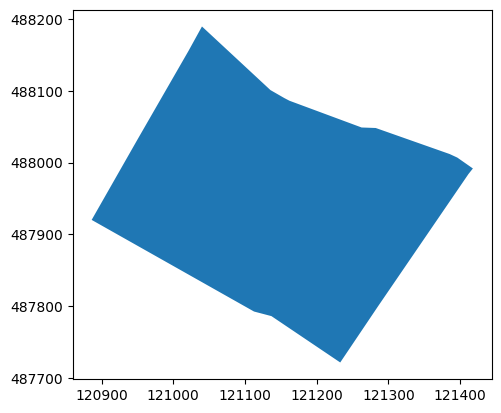

In [49]:
ams = gpd.read_file('../data/raw_data/AMS_Buurten_lnglat.json').to_crs(28992)
ams = ams.loc[(ams['Buurtcode']  == 'AC01')]
ams.plot()

In [50]:
ams_outline = ams.dissolve().boundary

<Axes: >

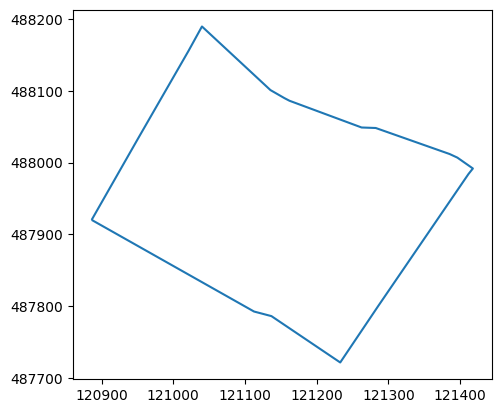

In [51]:
ams_outline.plot()

In [26]:
# Link to the building file
path = "../data/raw_data/3DBAG/Amsterdam_buildings.gpkg"

# Load buildings
all_buildings = gpd.read_file(path)

In [52]:
buildings = all_buildings.clip(ams)

<Axes: >

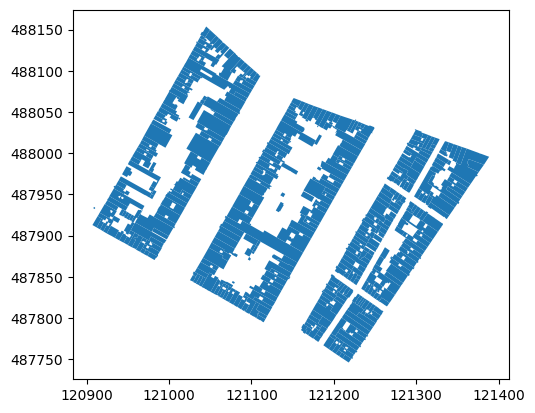

In [53]:
# Plot the building footprints to check if it looks appropriate.
buildings.plot()

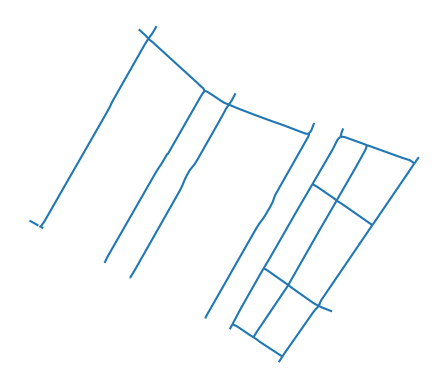

In [57]:
### FILTERED STREET DATASET
streets = gpd.read_file('../data/raw_data/ams_wegvakken.gpkg', mask = ams).to_crs(28992)
streets = streets.clip(ams)
streets = streets[streets['FRC'].isin(['1','6'])]
streets = streets[['geometry']] # keep only the geometry column
streets = streets.explode(ignore_index=True) 
ax = streets.plot()
ax.set_axis_off()

<Axes: >

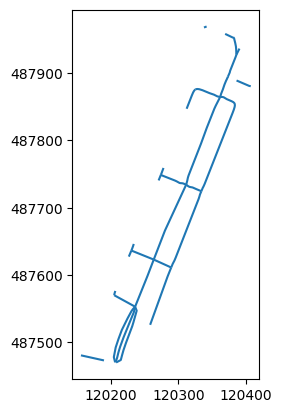

In [31]:
streets.plot()

<Axes: >

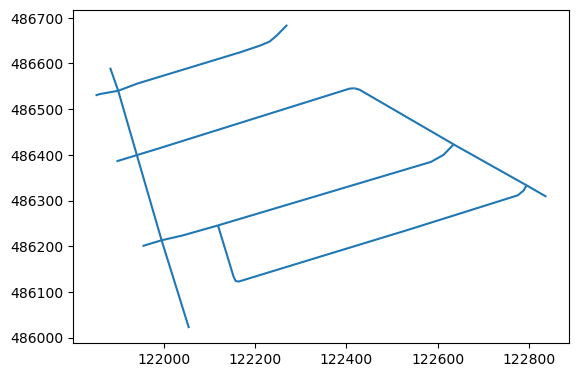

In [13]:
all_waterways = gpd.read_file('../data/raw_data/NL_vaarwegvakken.json').to_crs(28992)

waterways = all_waterways.clip(ams.buffer(50))


# Filter dataframe to only contain the geometry
waterways = waterways[['geometry']]

# Explode the geometry to get rid of multilines
waterways = waterways.explode(ignore_index=True)

# Show the first few rows to check if it was loaded
waterways.plot()

__Let's create a persistent unique identifier for each building__

In [58]:
%%time
# Clean up the dataframe. We only need the height and geometry information. 
## Height was already calculated prior to this - the 3DBAG comes with different calculated heights (INCLUDE THE HEIGHT OVERVIEW). 
## We use 70th percentile height because it most accurately represents the true height of the building. 
buildings = buildings[['height_70p','geometry']]

# Preprocess buildings (clean up small buildings that are likely uninhabitable, and eliminate multipolygons)
buildings = mm_preprocess_fixed(buildings, size=30, compactness=0.2, islands=True, loops=2, verbose=True)

# Create a persistent unique identifyer for each building
buildings["uID"] = range(len(buildings))



Loop 1 out of 2.


Identifying changes:   0%|          | 0/421 [00:00<?, ?it/s]

Changing geometry: 0it [00:00, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/382 [00:00<?, ?it/s]

Changing geometry: 0it [00:00, ?it/s]

CPU times: user 139 ms, sys: 14.6 ms, total: 153 ms
Wall time: 165 ms


In [59]:
buildings.dtypes

height_70p     float64
geometry      geometry
uID              int64
dtype: object

In [60]:
buildings.head()

,height_70p,geometry,uID
0,14.092267,"POLYGON ((121080.415 488088.673, 121080.866 48...",0
1,11.932546,"POLYGON ((121097.507 488090.988, 121097.942 48...",1
2,13.744204,"POLYGON ((121037.785 488107.906, 121039.125 48...",2
3,1.978695,"POLYGON ((121098.008 488090.706, 121098.353 48...",3
4,12.803519,"POLYGON ((121095.509 488094.317, 121094.734 48...",4


In [35]:
buildings.loc[buildings.uID == 1561]

,height_70p,geometry,uID


In [14]:
boolean = buildings['uID'].duplicated().any() # True
boolean

False

## Step 5: Generate additional morphometric elements

Before we can start with morphometrics we have to generate additional elements - tessellation and tessellation based blocks.\

To include: Explain tesselation

e.g.: But what is tesselation?

A Tessellation (or Tiling) is when we cover a surface with a pattern of flat shapes so that there are no overlaps or gaps.




In [61]:
limit = mm.buffered_limit(buildings, 100)

morph_tessellation = mm.Tessellation(buildings, "uID", limit, verbose=False)
morph_tessellation = morph_tessellation.tessellation

### 5.1 Enclosed tessellation (Parallel)

In [62]:
check = mm.CheckTessellationInput(buildings)

Collapsed features  : 0
Split features      : 4
Overlapping features: 0


In [63]:
%%time
limit = mm.buffered_limit(buildings, buffer=100)


# Extend linestrings from gdf to itself or target within a set tolerance
extended = mm.extend_lines(streets, tolerance=120, target=gpd.GeoSeries([limit.boundary]), barrier=buildings)

# Extend linestrings from gdf to itself or target within a set tolerance
# extended_water = mm.extend_lines(waterways, tolerance=120, target=gpd.GeoSeries([limit.boundary]), barrier=buildings)

enclosures = mm.enclosures(primary_barriers=extended, additional_barriers=[ams_outline], limit=gpd.GeoSeries([limit]))

CPU times: user 67.7 ms, sys: 2.92 ms, total: 70.6 ms
Wall time: 83.8 ms


/Users/lbeuster/Documents/TU Delft/Projects/3dgeo_scalable_gis/.venv/lib/python3.11/site-packages/geopandas/array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as Amersfoort / RD New (the single non-null crs provided).
  warnings.warn(
/Users/lbeuster/Documents/TU Delft/Projects/3dgeo_scalable_gis/.venv/lib/python3.11/site-packages/geopandas/array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as Amersfoort / RD New (the single non-null crs provided).
  warnings.warn(


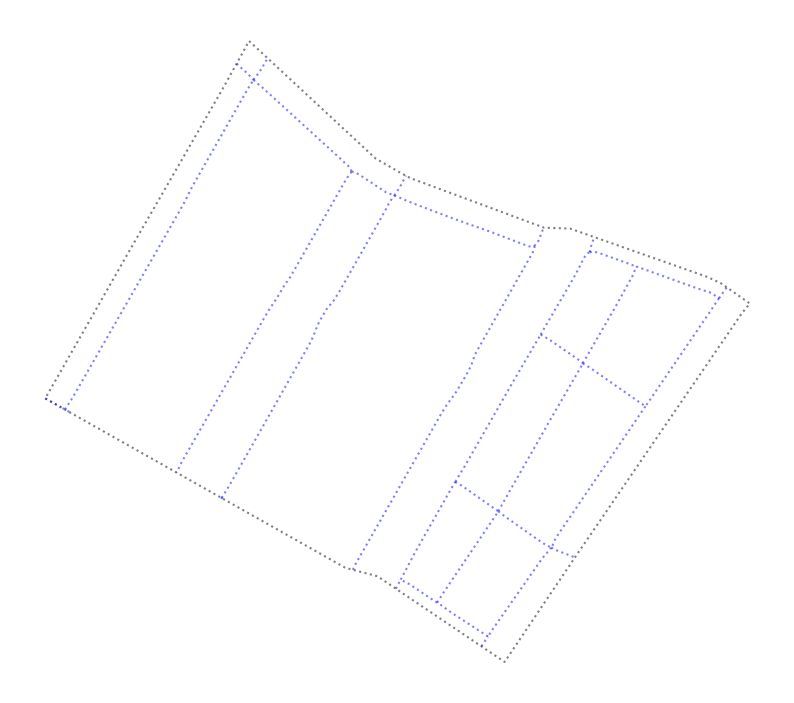

In [64]:
ax = ams_outline.plot(edgecolor='black', facecolor='none', linestyle='dotted', alpha=.5, figsize=(10, 10))
streets.plot(ax=ax, edgecolor='blue', facecolor='none', linestyle='dotted', alpha=.5)
# extended_water.plot(ax=ax, edgecolor='red', facecolor='none', alpha=.5)
ax.set_axis_off()

<Axes: >

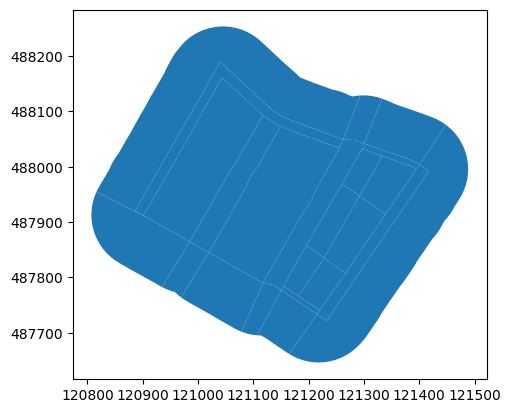

In [65]:
enclosures.plot()

In [66]:
%%time
enclosed_tess = mm.Tessellation(buildings, unique_id='uID', enclosures=enclosures, use_dask=True).tessellation

# to conform with the rest of the code:
tessellation = enclosed_tess

CPU times: user 77.3 ms, sys: 29.3 ms, total: 107 ms
Wall time: 2.48 s


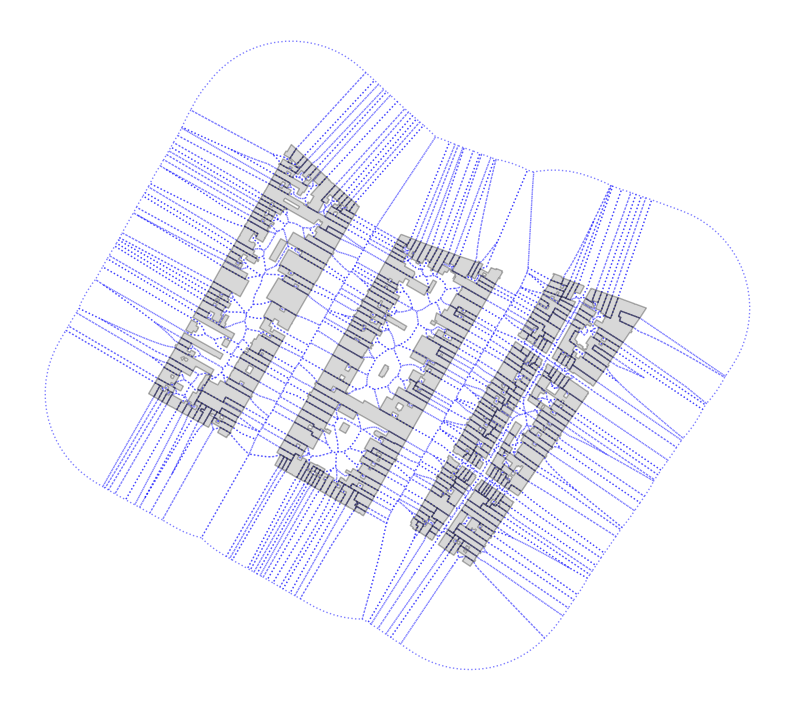

In [67]:
ax = morph_tessellation.plot(edgecolor='blue', facecolor='none', linestyle='dotted', alpha=.5, figsize=(10, 10))
buildings.plot(ax=ax, edgecolor='black', facecolor='grey', alpha=0.3)
ax.set_axis_off()

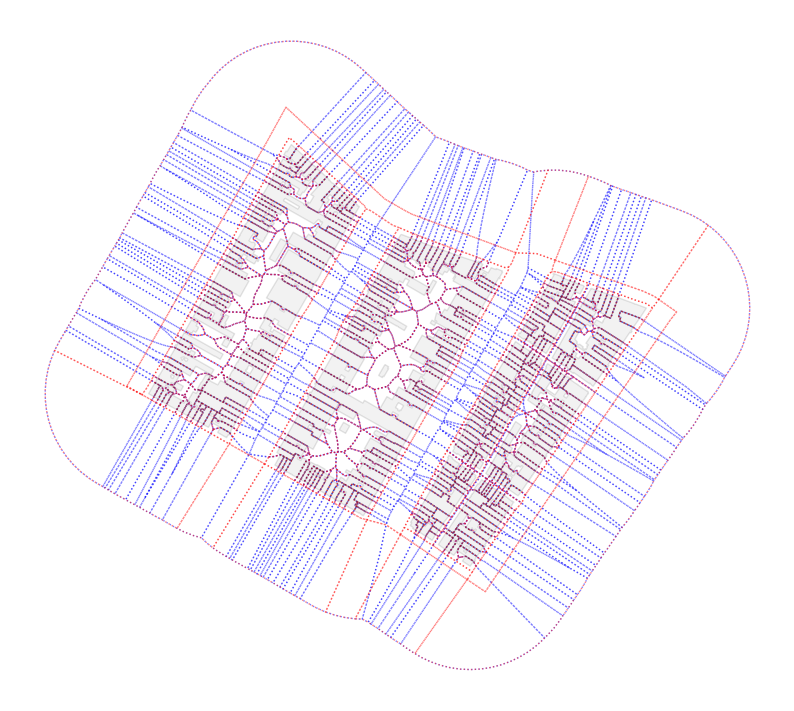

In [68]:
ax = morph_tessellation.plot(edgecolor='blue', facecolor='none', linestyle='dotted', alpha=.5, figsize=(10, 10))
enclosed_tess.plot(ax=ax, edgecolor='red', facecolor='none', linestyle='dotted', alpha=.5)
buildings.plot(ax=ax, edgecolor='black', facecolor='grey', alpha=0.1)
ax.set_axis_off()

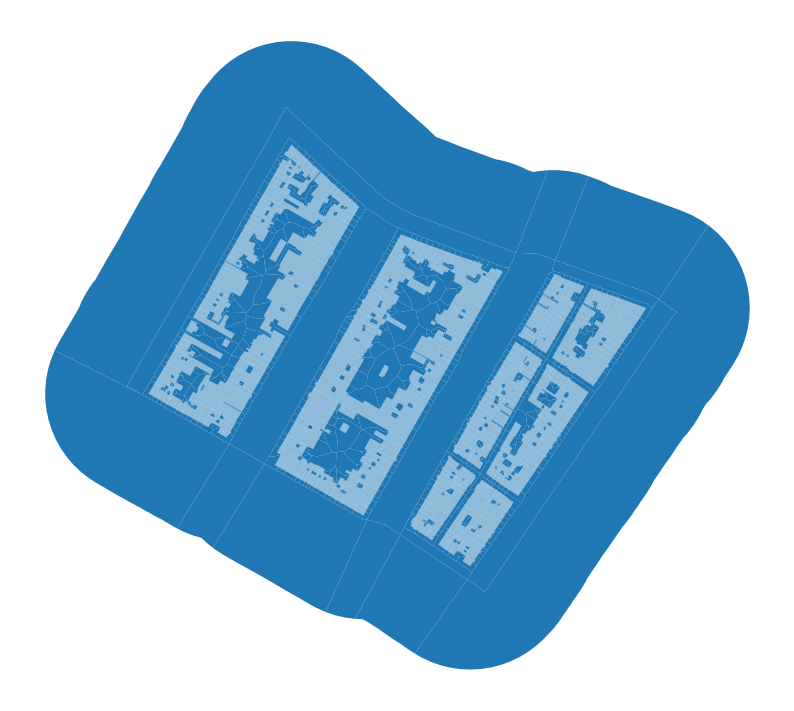

In [69]:
ax = enclosed_tess.plot(figsize=(10, 10))
buildings.plot(ax=ax, color='white', alpha=.5)
ax.set_axis_off()